# import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import math
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, ReLU, BatchNormalization, GlobalAveragePooling2D,Activation
import pandas as pd
import numpy as np
from tensorflow.keras import datasets, layers, models,Sequential
import matplotlib.pyplot as plt

# data load

In [2]:
train_data = np.load('train.npy')
train_data = np.reshape(train_data,(30000,28,28,1)).astype(float)
train_data_show = np.reshape(train_data,(30000,28,28)).astype(float)

test_data = np.load('test.npy')
test_data = np.reshape(test_data,(5000,28,28,1)).astype(float)

train_label = pd.read_csv('train.csv')['label']

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)

(30000, 28, 28, 1)
(5000, 28, 28, 1)
(30000,)


# show part of the images

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

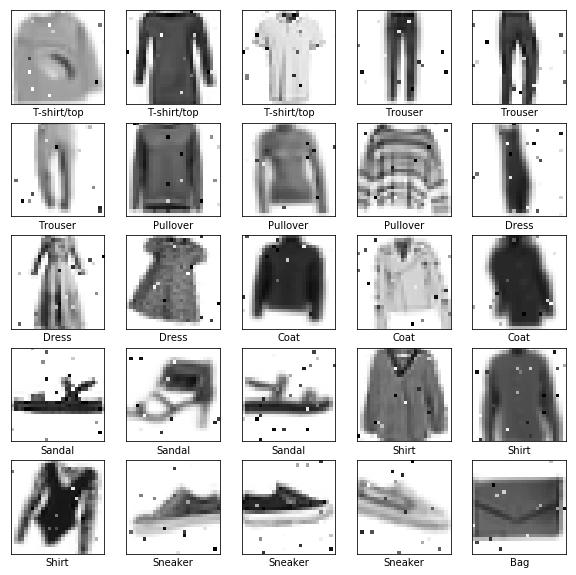

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data_show[1000*i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_label[1000*i]])
plt.show()

# data processing

## normalization

In [5]:
train_data = train_data.astype('float32')/255
test_data = test_data.astype('float32')/255

## shuffle

In [6]:
index=np.arange(30000)
np.random.shuffle(index)

train_data=train_data[index,:,:,:]#X_train是训练集，y_train是训练标签

train_label=train_label[index]

## one-hot encode

In [7]:
train_label = tf.keras.utils.to_categorical(train_label,10)
print(train_label.shape)

(30000, 10)


## further divide the data

In [8]:
(x_train, x_valid) = train_data[5000:], train_data[:5000] 
(y_train, y_valid) = train_label[5000:], train_label[:5000]


# model

## build the wheel 

### basic unit: conv + batch normalization + relu

In [9]:
class ConvBNRelu(tf.keras.Model):
    def __init__(self, channel, kernel_size=3, strides=1, padding='same'):
        super(ConvBNRelu, self).__init__()
        self.model = tf.keras.models.Sequential([
            Conv2D(channel, kernel_size, strides=strides, padding=padding),
            BatchNormalization(),
            ReLU()
        ])

    def call(self, x):
        x = self.model(x)
        return x

### inception unit 

In [10]:
class InceptionBlk(tf.keras.Model):
    def __init__(self, channel, strides=1):
        super(InceptionBlk, self).__init__()
        self.channel = channel
        self.strides = strides
        self.conv1 = ConvBNRelu(2*channel, kernel_size=1, strides=strides)

        self.conv2_1 = ConvBNRelu(3*channel, kernel_size=1, strides=1)
        self.conv2_2 = ConvBNRelu(4*channel, kernel_size=3, strides=strides)
        
        self.conv3_1 = ConvBNRelu(math.floor(0.5*channel), kernel_size=1, strides=1)
        self.conv3_2 = ConvBNRelu(channel, kernel_size=5, strides=strides)
        
        self.pool = MaxPooling2D(3, strides=1, padding='same')
        self.pool_conv = ConvBNRelu(channel,kernel_size=1, strides=strides)

    def call(self, x):
        x1 = self.conv1(x)
        x2_1 = self.conv2_1(x)
        x2_2 = self.conv2_2(x2_1)
        x3_1 = self.conv3_1(x)
        x3_2 = self.conv3_2(x3_1)
        x4_1 = self.pool(x)
        x4_2 = self.pool_conv(x4_1)
        #按通道垒叠
        x = tf.concat([x1, x2_2, x3_2, x4_2], axis=3)
        return x

## define the model

### model1 普通的卷积池化全连接

In [11]:
model = tf.keras.Sequential()
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

### ConvBNRelu作基本单元搭的网络

In [16]:
model = tf.keras.Sequential()
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(ConvBNRelu(64,kernel_size=5,strides=2))
model.add(Dropout(0.3))
model.add(ConvBNRelu(64,kernel_size=3,strides=2))
model.add(Dropout(0.3))
model.add(ConvBNRelu(128,kernel_size=3,strides=2))
model.add(Dropout(0.3))
model.add(ConvBNRelu(128,kernel_size=3,strides=2))
model.add(Dropout(0.3))
model.add(ConvBNRelu(256,kernel_size=3,strides=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv_bn_relu_7 (ConvBNRelu)  (None, 14, 14, 64)        102720    
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv_bn_relu_8 (ConvBNRelu)  (None, 7, 7, 64)          37184     
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv_bn_relu_9 (ConvBNRelu)  (None, 4, 4, 128)         74368     
_________________________________________________________________
dropout_11 (Dropout)         (None, 4, 4, 128)        

### model2 两个InceptionBlk，不同步长

In [29]:
model = tf.keras.Sequential()

#model.add(ConvBNRelu(192))
model.add(Conv2D(192,kernel_size=3,padding='same',input_shape=(28,28,1)))

model.add(InceptionBlk(32,strides=2))

model.add(InceptionBlk(32,strides=1))
model.add(Dropout(0.3))


model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

#model.build(input_shape=(None,28, 28, 1))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 192)       1920      
_________________________________________________________________
inception_blk (InceptionBlk) (None, 14, 14, 256)       165168    
_________________________________________________________________
inception_blk_1 (InceptionBl (None, 14, 14, 256)       178480    
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
Total params: 348,138
Trainable params: 346,666
Non-trainable params: 1,472
___________________________________________

### model3 实现GoogLeNet缩短版

In [64]:
model = tf.keras.Sequential()

model.add(Conv2D(64,kernel_size=7,activation='relu',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=3,strides=2))

model.add(Conv2D(64,kernel_size=1,activation='relu'))
model.add(Conv2D(192,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=3,strides=2,padding='same'))

model.add(InceptionBlk(32))
model.add(InceptionBlk(34))
model.add(InceptionBlk(36))
model.add(InceptionBlk(38))
model.add(InceptionBlk(40))
model.add(MaxPooling2D(pool_size=3,strides=2))

model.add(InceptionBlk(32))
model.add(InceptionBlk(64))

model.add(GlobalAveragePooling2D())

model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_380"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_414 (Conv2D)          (None, 22, 22, 64)        3200      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_415 (Conv2D)          (None, 10, 10, 64)        4160      
_________________________________________________________________
conv2d_416 (Conv2D)          (None, 8, 8, 192)         110784    
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 4, 4, 192)         0         
_________________________________________________________________
inception_blk_58 (InceptionB (None, 4, 4, 256)         165168    
_________________________________________________________________
inception_blk_59 (InceptionB (None, 4, 4, 272)      

## ResNet

### Bottleneck Residual Block

In [11]:
class BottleneckBlock(layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = Conv2D(filter_num//4, kernel_size=[1, 1], strides=stride, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()

        self.conv2 = Conv2D(filter_num//4, kernel_size=[3, 3], strides=1, padding='same')
        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()
        
        self.conv3 = Conv2D(filter_num, kernel_size=[1, 1], strides=1, padding='same')
        self.bn3 = BatchNormalization()
        
        if stride != 1:
            self.downsample = Sequential()
            self.downsample.add(Conv2D(filter_num, kernel_size=[1, 1], strides=stride))
        else:
            self.downsample = lambda x:x

    def call(self, inputs, training=None):
        out = self.conv1(inputs)  
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(inputs)

        output = layers.add([out, identity])
        output = tf.nn.relu(output)
        return output


### Res Block

In [12]:
class ResNet(tf.keras.Model):
    def __init__(self, layer_dims, num_classes):
        super(ResNet, self).__init__()
        self.stem = Sequential([Conv2D(64, (3,3), strides=(1, 1)),
                                BatchNormalization(),
                                ReLU(),
                                MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')])

        self.layer1 = self.build_resblock(64, layer_dims[0])
        self.layer2 = self.build_resblock(128, layer_dims[1], stride=2)
        self.layer3 = self.build_resblock(256, layer_dims[2], stride=2)
        self.layer4 = self.build_resblock(512, layer_dims[3], stride=2)
        self.avgpool = GlobalAveragePooling2D()
        self.fc = Dense(num_classes,activation='softmax')

    def call(self,inputs, training=None):
        x = self.stem(inputs)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        return x

    def build_resblock(self, filter_num, blocks, stride=1):
        res_blocks = Sequential()
        res_blocks.add(BottleneckBlock(filter_num, stride))

        for _ in range(1, blocks):
            res_blocks.add(BottleneckBlock(filter_num, stride=1,)) 
        return res_blocks



### Res Net 模型

In [13]:
model = ResNet([2, 3, 4, 1],10)
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  896       
_________________________________________________________________
sequential_1 (Sequential)    multiple                  9664      
_________________________________________________________________
sequential_2 (Sequential)    multiple                  61376     
_________________________________________________________________
sequential_4 (Sequential)    multiple                  311040    
_________________________________________________________________
sequential_6 (Sequential)    multiple                  381184    
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5130

## compile the model

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## train the model

In [15]:
BATCH_SIZE = 32
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=0,
                            patience=3,
                            verbose=0,
                            mode='max')
                    ])

(25000, 28, 28, 1)
(25000, 10)
(5000, 28, 28, 1)
(5000, 10)
Train on 25000 samples, validate on 5000 samples
Epoch 1/50
25000/25000 [==============================] - 459s 18ms/sample - loss: 0.7864 - accuracy: 0.7079 - val_loss: 0.6874 - val_accuracy: 0.7404
Epoch 2/50
25000/25000 [==============================] - 461s 18ms/sample - loss: 0.5212 - accuracy: 0.8054 - val_loss: 0.6126 - val_accuracy: 0.7728
Epoch 3/50
25000/25000 [==============================] - 446s 18ms/sample - loss: 0.4473 - accuracy: 0.8300 - val_loss: 0.5805 - val_accuracy: 0.7826
Epoch 4/50
25000/25000 [==============================] - 490s 20ms/sample - loss: 0.4124 - accuracy: 0.8428 - val_loss: 0.4323 - val_accuracy: 0.8388
Epoch 5/50
25000/25000 [==============================] - 443s 18ms/sample - loss: 0.3705 - accuracy: 0.8611 - val_loss: 0.5105 - val_accuracy: 0.8050
Epoch 6/50
25000/25000 [==============================] - 444s 18ms/sample - loss: 0.3404 - accuracy: 0.8712 - val_loss: 0.3818 - val_ac

# predict

In [16]:
y_predict = model.predict(test_data)
y_predict = np.array([np.argmax(one_hot)for one_hot in y_predict])

index = np.arange(5000);
y_predict = y_predict.reshape(5000,1);
index = index.reshape(5000,1);

y_predict = np.hstack((index,y_predict));

y_predict = pd.DataFrame(y_predict)

y_predict.columns=['image_id','label'];

y_predict.to_csv('test_model22.csv', index=False)

